# Detecção de Fraudes em Cartões de Crédito

Neste projeto, irei abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.

<p align=center>
<img src="https://github.com/felipeapellegrini/data_science_portfolio/blob/master/cartoes.jpeg?raw=true" width="60%"></p>

Dentre essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de *machine learning* apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usarei neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="https://github.com/felipeapellegrini/data_science_portfolio/blob/master/atm.jpeg?raw=true" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [12]:
# importar os pacotes necessários
import pandas as pd # análise e tratamento de dados
import numpy as np # álgebra e transformação matemática
import matplotlib.pyplot as plt # visualização de dados simples
import seaborn as sns # visualização de dados mais robusta
import scikitplot as skplt # 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

import os


%matplotlib inline

#configurando o estilo dos gráficos com o Seaborn
sns.set_style('dark')

# verificar diretório de trabalho
os.getcwd()

'C:\\ProjetosDataScience\\20200217 - [PROJETO] Detecção de Fraudes em Cartão de Crédito\\4 - Analises'

In [13]:
#importar os dados
file_path = 'C:\\ProjetosDataScience\\20200217 - [PROJETO] Detecção de Fraudes em Cartão de Crédito\\1 - Dados Originais\creditcard.csv' # caminho do arquivo

df = pd.read_csv(file_path) # carregando arquivo para um dataframe

## Análise Exploratória

Olhando as cinco primeiras entradas observo que:

* A transformação PCA deixou as *features* descaracterizadas e em valores numéricos
* As colunas `Time` e `Amount` foram preservadas
* A variável alvo está representada na coluna `Class`, onde:
    * **0:** Transação normal;
    * **1:** Transação fraudulenta


In [14]:
# ver as cinco primeiras observações
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Observando um resumo estatístico do *dataset* a partir do método `describe()` posso notar que não existem discrepâncias aparentes nem outliers, exceto para a variável `Amount`, que em sua maioria é composta de valores pequenos, porém seu maior valor foge à essa regra.

In [15]:
df.describe() # descrição estatística dos dados

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Ao verificar a qualidade do conjunto de dados quanto à presença de dados vazios, vejo que este é um *dataset* de alta qualidade, não contendo nenhum valor nulo ou vazio.

In [17]:
# verificar valores ausentes
df.isnull().sum().max() # somar todos os verdadeiros para entradas vazias, o max é apenas para encurtar o output

0

Como informado na [descrição dos dados] (https://www.kaggle.com/mlg-ulb/creditcardfraud), as entradas relativas à transações fraudulentas correspondem a 0,17% dos dados.

Posso observar através de um gráfico de barras, o tamanho dessa discrepância e imaginar o tanto que ela irá impactar no aprendizado do modelo de *machine learning*.

Para resolver isso, farei um rebalanceamento dos dados usando o método de `UnderSampling` antes de alimentar o modelo final de classificação

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.1727% do dataset.



[]

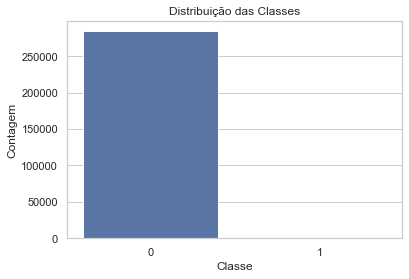

In [92]:
# ver o balanceamento de classes
print(df.Class.value_counts()) 
print("\nFraudes representam {:.4f}% do dataset.\n".format((df[df.Class==1].shape[0]/df.shape[0])*100))

# plotar grafico de barras para as classes
fig, ax = plt.subplots() # criando os objetos
sns.countplot('Class', data=df, ax=ax) # invocando gráfico de contagem

# configurando legendas e títulos
ax.set_title('Distribuição das Classes')
ax.set_xlabel('Classe')
ax.set_ylabel('Contagem')

# chamando o objeto gráfico
plt.plot();

Plotei um histograma para verificar a distribuição de tempo entre as transações normais e um para as transações fraudulentas.
Não consegui aproveitar nenhum padrão, inclusive por não se tratar de tempo de transação e sim de "quanto tempo se passou da primeira transação do conjunto de dados até a trasação atual.".

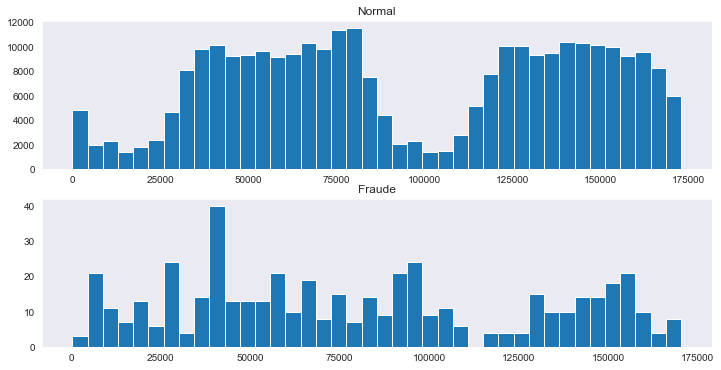

In [38]:
# criando objeto gráfico
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins = 40 # armazenando número de bins na variável

# invocando gráfico de histogramas de tempo para os objetos
ax[0].hist(df.Time[df.Class==0], bins=num_bins)
ax[1].hist(df.Time[df.Class==1], bins=num_bins)

# configurando legendas e títulos
ax[0].set_title('Normal')
ax[1].set_title('Fraude');

Comparei os valores `Amount` de transação normal e fraudulenta a partir de um *boxplot* e percebi uma distribuição diferente para as classes, o que provavelmente irá contribuir para o aprendizado do modelo.

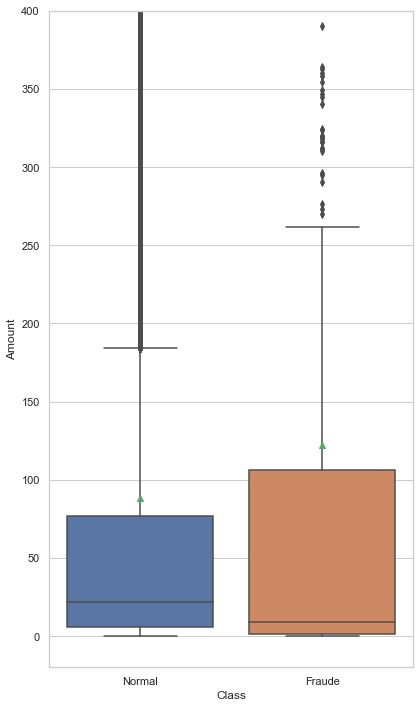

In [96]:
# criando objeto gráfico
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

# invocando boxplot para o objeto gráfico
sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)

# configurando valores do eixo y
plt.ylim((-20, 400))

# configurando nomes das variáveis
plt.xticks([0, 1], ['Normal', 'Fraude'])

# método que otimiza automaticamente o preenchimento do gráfico
plt.tight_layout()

O gráfico de densidade é muito útil para comparar a distribuição de cada variável para cada classe e ver quais as mais importantes para a detecção de anomalias.

Aqui eu procuro distribuições que sejam diferentes entre as classes, para poder identificar fraudes mais facilmente.

As variáveis `V3`, `V4`, `V10`, `V11` por exemplo, apresentam distribuições bem distintas, enquanto `V8`, `V13`e `V15` apresentam aproximadamente o mesmo comportamento.

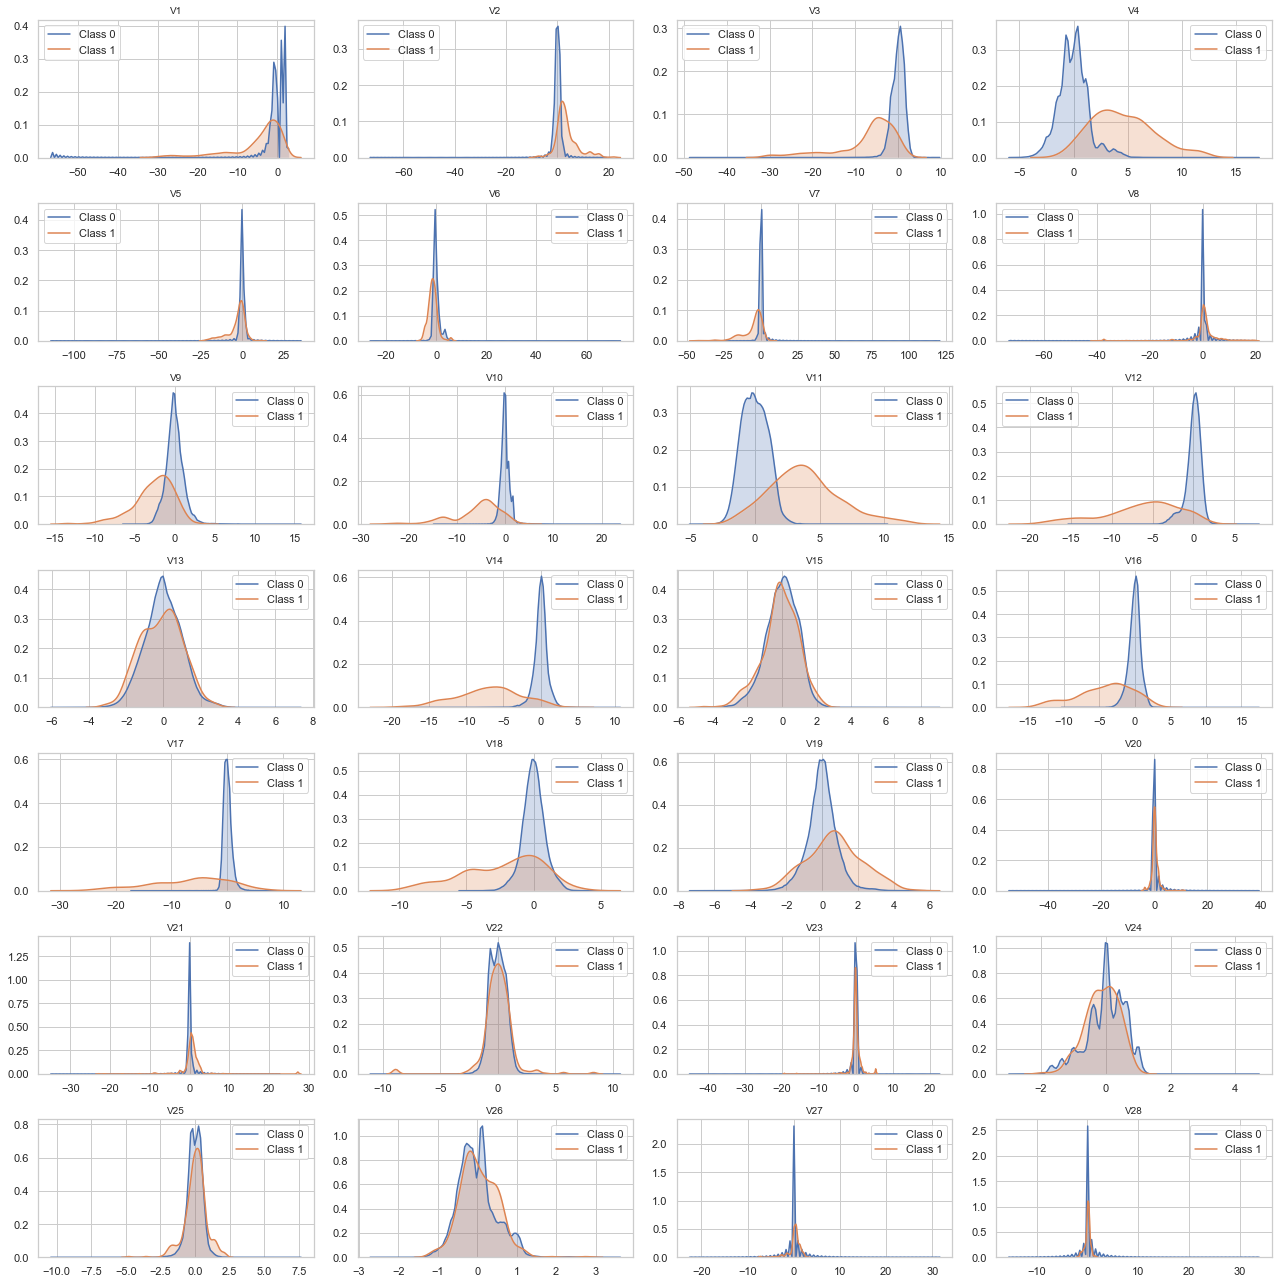

In [79]:
# armazenando nome das variáveis explanatórias na variável
column_names = df.drop(['Class', 'Amount', 'Time'], axis = 1).columns

# armazenando número de colunas na variável
num_plots = len(column_names)

# separando datasets entre 0 e 1
df_0 = df[df.Class==0]
df_1 = df[df.Class==1]

# criando objeto gráfico
fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

# criando estrutura de repetição para automatizar a plotagem dos gráficos
idx = 0 # iniciando variável que controla o id da variável explanatória na plotagem

for col in column_names:
    idx += 1 # acrescenta 1 na variável de índice a cada volta da repetição
    plt.subplot(7, 4, idx) # acessa o objeto daquela variável explanatória
    sns.kdeplot(df_0[col], label = 'Class 0', shade=True) # gera o gráfico de densidade para não-fraude
    sns.kdeplot(df_1[col], label = 'Class 1', shade=True) # gera o gráfico de densidade para fraude
    plt.title(col, fontsize=10) # configura o título do subplot para o nome da variável
plt.tight_layout() # método que otimiza automaticamente o preenchimento do gráfico

Resumidamente, algumas observações principais que pude extrair dessa etapa exploratória foram:

* O *dataset* está muito desbalanceado, uma vez que as transações fraudulentas representam apenas 0,17% das entradas totais.
* Não existem valores ausentes ou nulos no *dataframe*.
* Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa que as *features* originais foram padronizadas.
* As colunas `Time` e `Amount` não estão normalizadas.

## Preparando os dados

Para que os dados possam alimentar o modelo de Regressão Logística que vou construir, nesta etapa de preparação irei:

* Padronizar as *features* `Time` e `Amount`, que estão em outra ordem de grandeza.
* Dividir entre dados de treino e teste
* Balancear os dados a fim de evitar uma baixa performance para a classe 1 e *overfitting*.

### Padronizar `Time` e `Amount`

Para esta etapa, uma vez que a coluna `Amount` possui outliers, usarei a padronização por meio da classe `StandardScaler`.

In [82]:
# padronizar as colunas Time e Amount
df_clean = df.copy() # criar copia de segurança no dataframe

std_scaler = StandardScaler() # invocar o método que faz a padronização

df_clean['stdAmount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1,1))
df_clean['stdTime'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1,1))
# por executar o método separando cada coluna, o resultado é um array de apenas uma dimensão
# por isso deve passar pelo processo de reshaping, para que seja transformado em um array bidimensional

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True) # eliminar as colunas originais para ficar só com as normalizdas

# ver as 5 primeiras observações
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,stdAmount,stdTime
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


#### Dividir dados entre treino e teste

Vou dividir os dados entre dados de treino e de teste antes de proceder com o rebalanceamento. Com isso eu terei condições de comparar e identificar se o balanceamento foi adequado.

Para garantir que os conjuntos de treino e teste tenham a mesma proporcionalidade de classes, passarei o parâmetro `stratify=y`, que é minha variável de resposta.

In [85]:
# separar variáveis explanatória e de resposta (X e y)
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

# dividir o conjunto em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.3)

#### Balanceamento dos dados

Usando a biblioteca `imblearn` é possível aplicar facilmente técnicas de balanceamento de dados. Minha opção neste projeto foi usar *Under-sampling*, preservando a classe minoritária.

É fácil perceber que não há mais aquela discrepância inicial, presente no gráfico de barras no começo deste *notebook*)

1    344
0    344
Name: Class, dtype: int64


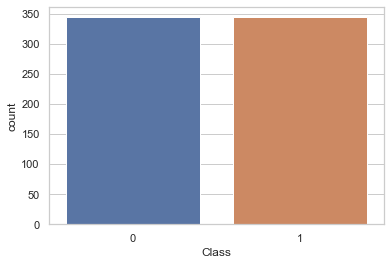

In [86]:
# rebalancear usando under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_rus);

Com os dados balanceados, é possível verificar através de uma matriz de correlação quais variáveis estão mais fortemente relacionadas com as outras.

Antes do balanceamento dos dados, a matriz de correlação não trazia nenhuma informalção relevante, contudo, ela traz muito mais informações após um correto balanceamento.

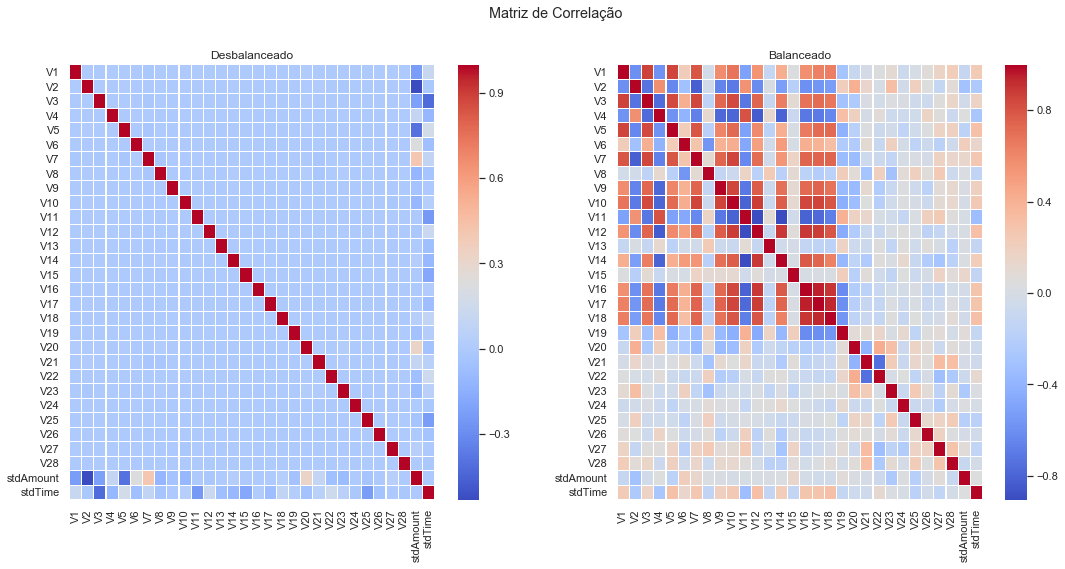

In [97]:
# plotar a matriz de correlação
corr = X_train.corr() # gerar matriz de correlação para os dados desbalanceados
corr_rus = pd.DataFrame(X_rus).corr() # gerar matriz de correlação para os dados balanceados

# criando objeto gráfico
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
fig.suptitle('Matriz de Correlação') # configurando título do objeto

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
           linewidths=0.1, cmap='coolwarm', ax=ax[0]) # chamando mapa de calor para os dados desbalanceados
ax[0].set_title('Desbalanceado') # configurando título do subplot desbalanceado

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
           linewidths=0.1, cmap='coolwarm', ax=ax[1]) # chamando mapa de calor para os dados balanceados
ax[1].set_title('Balanceado'); # configurando o título do subplot balanceado


## Modelo de Machine Learning

Com todos os dados preparados e após uma análise exploratória completa, irei construir um classificador usando a Regressão Logística.

Após instanciar o modelo, o mesmo será treinado em cima dos dados em `X_rus` e `y_rus`. Na sequência, realizarei as previsões sobre os dados de teste.

In [98]:
# instanciar e treinar um modelo de Regressão Logística
np.random.seed(2) # gerando uma constante para a geração de dados aleatórios
model = LogisticRegression() # invocando método de regressão logística
model.fit(X_rus, y_rus) # ajustando modelo aos dados BALANCEADOS


# fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_test) # gerando previsão exata para os dados de teste
y_prob = model.predict_proba(X_test) # gerando previsão probabilística para os dados de teste

Com o modelo treinado e as previsões feitas, sigo para a avaliação do desempenho.

Neste tipo de problema, originalmente desbalanceado, a acurácia não é uma métrica adequada, pois podemos ter uma acurácia de 99.88% e detectar menos de 60% das fraudes (isso porque o modelo acerta muito pouco os verdadeiros positivos mas acerta muito os verdadeiros negativos, puxando a acurácia).

Vejamos a matriz de confusão para ver a taxa de acertos para transações fraudulentas, ou pela coluna *recall* do Relatório de Classificação.

Uma outra métrica considerada interessante para se avaliar a eficácia é a [AUC_ROC](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772), ou área sob curva. No caso desse modelo de Regressão Logística, temos 94% de AUC.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9616    0.9804     85295
           1     0.0399    0.9189    0.0764       148

    accuracy                         0.9615     85443
   macro avg     0.5199    0.9403    0.5284     85443
weighted avg     0.9982    0.9615    0.9788     85443

Acurácia: 0.9615

AUC: 0.9403



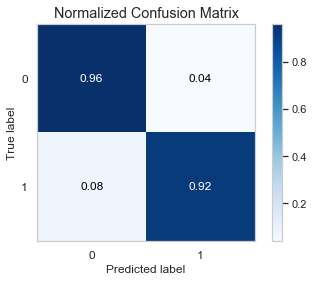

In [99]:
# plotar a mariz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# imprimir relatório de classificação
print('Relatório de Classificação:\n', classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print('Acurácia: {:.4f}\n'.format(accuracy_score(y_test, y_pred)))

# imprimir área sob a curva
print('AUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred)))

## Conclusões

Como você pode observar, não se trata de um problema trivial. Apesar dos dados estarem bem tratados e limpos, sem valores ausentes ou variáveis categóricas, o desbalanceamento e a Transformação PCA demandaram um trabalho considerável.

Obviamente, apesar do bom resultado final, há espaço para testar o desempenho com outros algoritmos de classificação, além de otimizar seus parâmetros.